# HBURS, project 2
by Alessandro G. Magnasco

In [1]:
## System imports

# system library
import os

# math & data operations libraries
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pylab import rcParams # for feature density plotting

# machine learning libraries
import mglearn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay # sklearn v.1.1
from sklearn.utils import resample

# charting libraries
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

# python errors and warnings for debug
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126378 entries, 0 to 126377
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   BBL            126378 non-null  int64  
 1   OfficialViols  250 non-null     float64
 2   AEP            250 non-null     float64
 3   RepairCount    44128 non-null   float64
 4   RepairCost     44128 non-null   float64
 5   ClassB_count   110092 non-null  float64
 6   ClassB         110092 non-null  float64
 7   ClassC_count   77014 non-null   float64
 8   ClassC         77014 non-null   float64
 9   SumViols       126378 non-null  float64
 10  ViolsDiff      250 non-null     float64
dtypes: float64(10), int64(1)
memory usage: 10.6 MB


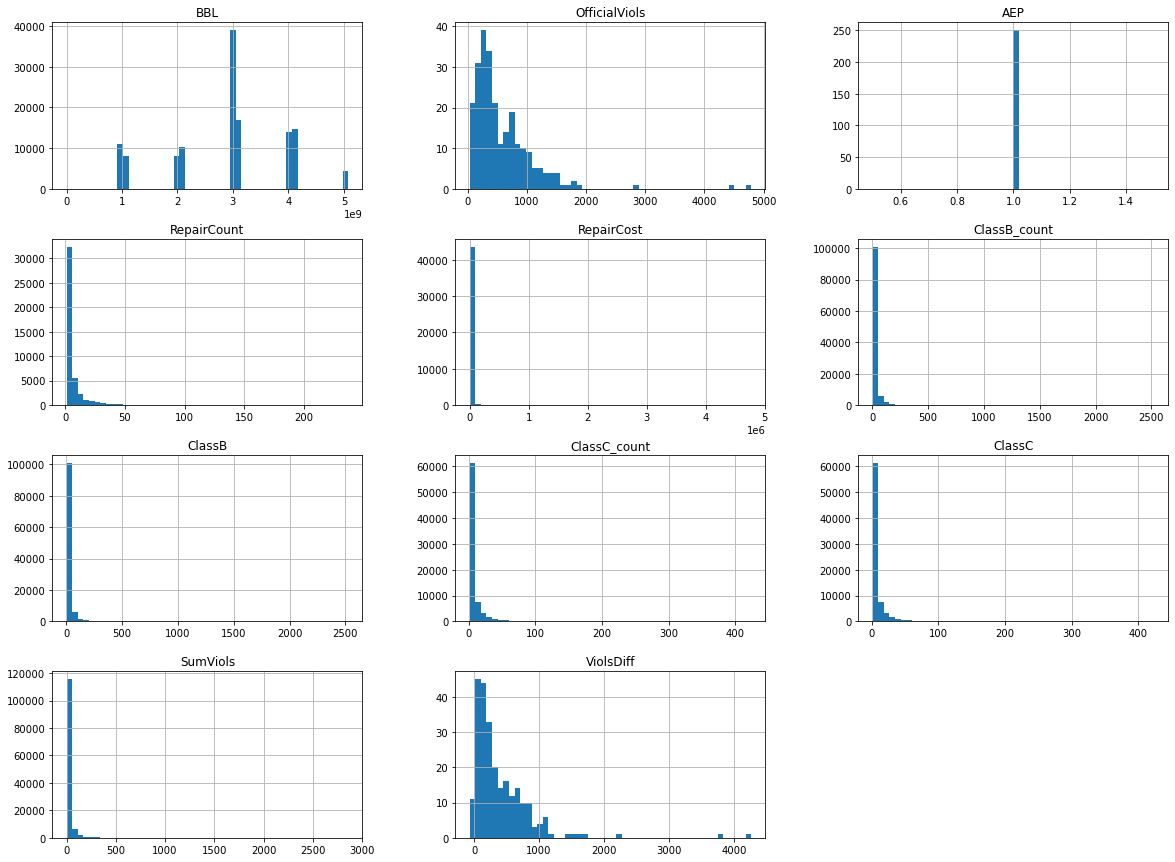

In [2]:
# Step 2.0 - import
bg=0
def import_cleaned_data():
    global bg
    bg = pd.read_csv(r'''bg.csv''', low_memory=False)

import_cleaned_data()
bg.info()

bg.hist(bins=50, figsize=(20,15)) # 20,15
plt.show()

In [3]:
# Step 2.1 - cleaning & split into training/testing

print('Count before dropping NAs: \n',bg.count())
# drop any row that contains any NA value in the parameter columns
bg_dn = bg.dropna(axis=0,how='any', subset=['RepairCost','ClassB','ClassC','RepairCount'])
print('\n\nCount after dropping NAs: \n',bg_dn.count())
# filling remaining NA values with 0
bg_n = bg_dn.fillna(axis=0,value=0)
print(bg_n.head(2000))

Count before dropping NAs: 
 BBL              126378
OfficialViols       250
AEP                 250
RepairCount       44128
RepairCost        44128
ClassB_count     110092
ClassB           110092
ClassC_count      77014
ClassC            77014
SumViols         126378
ViolsDiff           250
dtype: int64


Count after dropping NAs: 
 BBL              32986
OfficialViols      248
AEP                248
RepairCount      32986
RepairCost       32986
ClassB_count     32986
ClassB           32986
ClassC_count     32986
ClassC           32986
SumViols         32986
ViolsDiff          248
dtype: int64
             BBL  OfficialViols  AEP  RepairCount  RepairCost  ClassB_count  \
0     1002050018          186.0  1.0          6.0     6017.00          67.0   
1     1002390011          169.0  1.0          7.0     2286.00          68.0   
3     1003090021          238.0  1.0          4.0     8722.00          75.0   
4     1003100024          108.0  1.0         14.0   105142.37          37.0   
5  

In [4]:
# making a smaller, resampled dataset, since the supervised learning doesn't do well with the very uneven data

# cutting out the positive and negative values
bg_aep_y = bg_n[bg_n['AEP']==1]
bg_aep_n = bg_n[bg_n['AEP']==0]

# what is the size discrepancy?
print('Before upsampling, negative values have',bg_aep_n.shape[0],'values and positives are',bg_aep_y.shape[0],'.')

# downsampling the negative values
bg_aep_n_down = resample(bg_aep_n, n_samples=250, replace=True, random_state=4)

# putting the dataframe back together
bg_sm = pd.concat([bg_aep_n_down,bg_aep_y])

print('\n\nCount after making a smaller dataset:\n',bg_sm.count())

Before upsampling, negative values have 32738 values and positives are 248 .


Count after making a smaller dataset:
 BBL              498
OfficialViols    498
AEP              498
RepairCount      498
RepairCost       498
ClassB_count     498
ClassB           498
ClassC_count     498
ClassC           498
SumViols         498
ViolsDiff        498
dtype: int64


In [5]:
# Step 2.2: prepare data, split into features and target
data_sl = bg_n[['RepairCost','ClassB','ClassC','RepairCount']] # selecting features
target_sl = bg_n['AEP'].astype('int8') # this was already established as a dummy

# testing with the upsampled dataset
data_sm = bg_sm[['RepairCost','ClassB','ClassC','RepairCount']] # selecting features
target_sm = bg_sm['AEP'].astype('int8') # this was already established as a dummy

# selecting which size dataset to use
data = data_sm
target = target_sm

In [6]:
bg_sm.describe()

,BBL,OfficialViols,AEP,RepairCount,RepairCost,ClassB_count,ClassB,ClassC_count,ClassC,SumViols,ViolsDiff
count,4.980000e+02,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000
mean,2.588480e+09,293.829317,0.497992,13.512048,13898.545904,88.178715,88.178715,30.753012,30.753012,118.931727,202.809237
std,1.039869e+09,491.876133,0.500499,16.746328,36103.389612,96.538700,96.538700,32.965949,32.965949,124.718417,395.755989
min,1.002050e+09,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,-71.000000
25%,2.028035e+09,0.000000,0.000000,2.000000,1471.750000,18.000000,18.000000,6.000000,6.000000,26.250000,0.000000
50%,3.014845e+09,0.000000,0.000000,8.000000,5691.500000,64.000000,64.000000,20.500000,20.500000,90.500000,0.000000
75%,3.046880e+09,410.750000,1.000000,17.000000,14261.277500,119.000000,119.000000,42.000000,42.000000,158.000000,260.750000
max,5.057250e+09,4792.000000,1.000000,138.000000,585017.410000,639.000000,639.000000,187.000000,187.000000,820.000000,4269.000000


array([[<AxesSubplot:title={'center':'BBL'}>,
        <AxesSubplot:title={'center':'OfficialViols'}>,
        <AxesSubplot:title={'center':'AEP'}>],
       [<AxesSubplot:title={'center':'RepairCount'}>,
        <AxesSubplot:title={'center':'RepairCost'}>,
        <AxesSubplot:title={'center':'ClassB_count'}>],
       [<AxesSubplot:title={'center':'ClassB'}>,
        <AxesSubplot:title={'center':'ClassC_count'}>,
        <AxesSubplot:title={'center':'ClassC'}>],
       [<AxesSubplot:title={'center':'SumViols'}>,
        <AxesSubplot:title={'center':'ViolsDiff'}>, <AxesSubplot:>]],
      dtype=object)

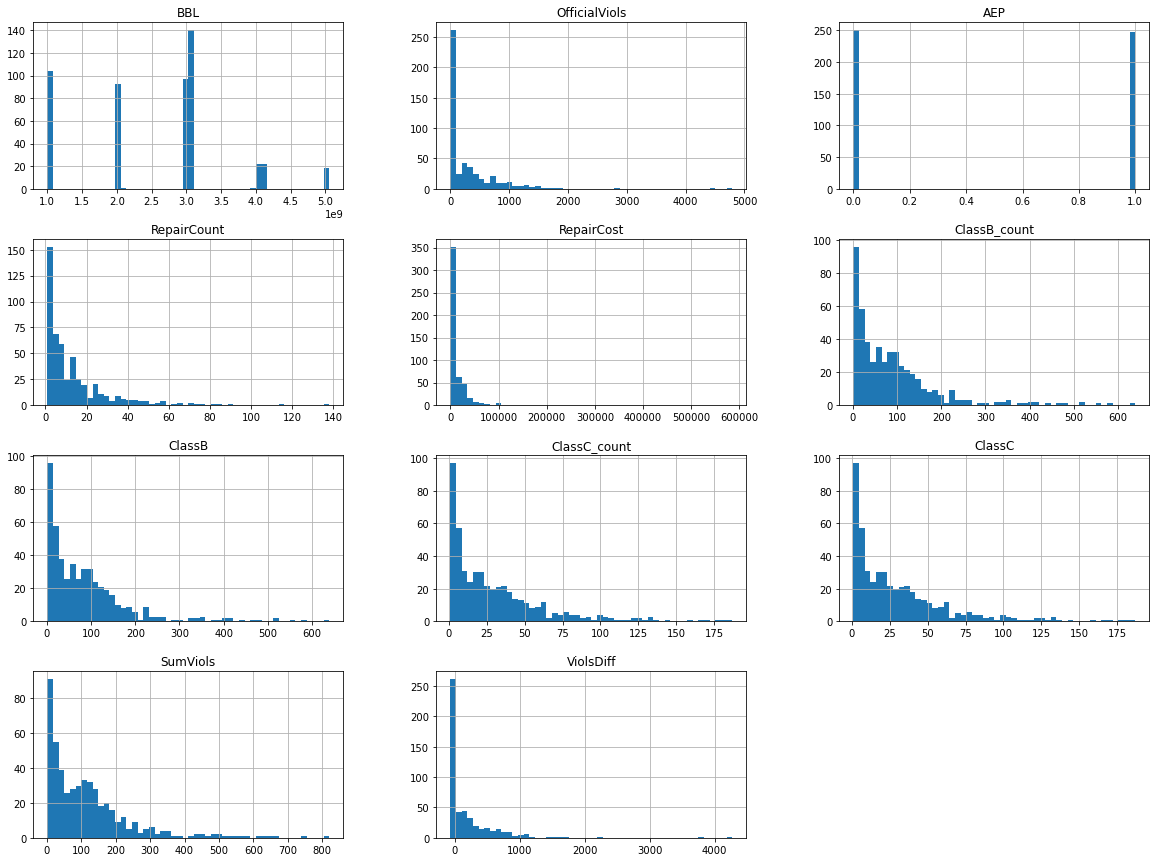

In [7]:
bg_sm.hist(bins=50, figsize=(20,15)) # 20,15

In [8]:
# quick sanity check
print('If >1, still have NA in data \n',pd.isna(data).nunique())
print('\nData values:\n',data.head())
print('\nIf >1, still have NA in target \n',pd.isna(target).nunique())
print('\nTarget values:\n',target[:5])

If >1, still have NA in data 
 RepairCost     1
ClassB         1
ClassC         1
RepairCount    1
dtype: int64

Data values:
        RepairCost  ClassB  ClassC  RepairCount
22000     3990.00     3.0     7.0          1.0
10143     2529.00    10.0    11.0          2.0
34699     1235.00    14.0    21.0          4.0
21389    29997.45    34.0    23.0         20.0
28675     4806.00    27.0    17.0          7.0

If >1, still have NA in target 
 1

Target values:
 22000    0
10143    0
34699    0
21389    0
28675    0
Name: AEP, dtype: int8


In [9]:
# stratified shuffle split
split = StratifiedShuffleSplit(
    n_splits=5, 
    test_size=0.2, # 20% testing and 80% training 
    random_state=4 # RNGs always spit out "4" for me anyway so might as well
)

## DOWNSAMPLED DATA
# using iloc to match the RNG index to the BBL index
for train_index, test_index in split.split(data, target):
    X_train = data.iloc[train_index]
    X_test = data.iloc[test_index]
    y_train_d = target.iloc[train_index]
    y_test_d = target.iloc[test_index]

# converting target sets into 1D arrays
y_train = y_train_d.values.ravel()
y_test = y_test_d.values.ravel()

print(X_train.describe())

## NON-SAMPLED DATA
# using iloc to match the RNG index to the BBL index
for train_index, test_index in split.split(data_sl, target_sl):
    X_train_sl = data_sl.iloc[train_index]
    X_test_sl = data_sl.iloc[test_index]
    y_train_d_sl = target_sl.iloc[train_index]
    y_test_d_sl = target_sl.iloc[test_index]

# converting target sets into 1D arrays
y_train_sl = y_train_d_sl.values.ravel()
y_test_sl = y_test_d_sl.values.ravel()

print(X_train_sl.describe())

# checking for NA values
#print('If !=1, still have NA in X_train \n',pd.isna(X_train).nunique())
#print('If !=1, still have NA in X_test \n',pd.isna(X_test).nunique())
#print('If !=0, still have NA in y_train \n',np.count_nonzero(np.isnan(y_train)))
#print('If !=0, still have NA in y_test \n',np.count_nonzero(np.isnan(y_test)))

          RepairCost      ClassB      ClassC  RepairCount
count     398.000000  398.000000  398.000000   398.000000
mean    14455.191080   87.914573   30.776382    13.924623
std     39644.954801   96.198434   33.339529    17.750704
min         0.000000    1.000000    1.000000     1.000000
25%      1431.500000   17.000000    6.000000     2.000000
50%      5691.500000   63.000000   20.000000     8.000000
75%     13640.500000  120.000000   41.000000    17.000000
max    585017.410000  639.000000  187.000000   138.000000
         RepairCost        ClassB        ClassC   RepairCount
count  2.638800e+04  26388.000000  26388.000000  26388.000000
mean   7.582362e+03     43.113461     14.297938      7.256177
std    3.743882e+04     63.894761     21.862188     12.596562
min    0.000000e+00      1.000000      1.000000      1.000000
25%    4.863750e+02      9.000000      3.000000      1.000000
50%    1.576000e+03     23.000000      7.000000      3.000000
75%    5.736288e+03     52.000000     16.000

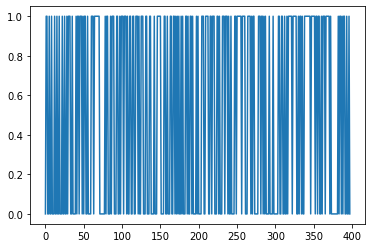

In [10]:
# Step 2.3: examine the target attribute
# Examine and plot the distribution of the target attribute in your training set (e.g., is it Gaussian, uniform, logarithmic). This will help you interpret the performance of different algorithms on your data.

plt.plot(y_train,
         #figsize=(12,8)
        )

(array([200., 198.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

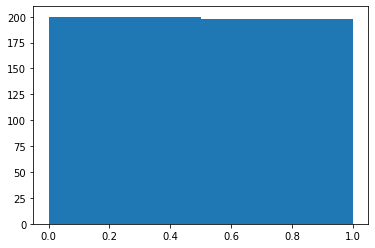

In [11]:
plt.hist(y_train,bins=2,
         #figsize=(12,8)
        ) # target attribute is split almost evenly now

Histogram: 
 [[<AxesSubplot:title={'center':'RepairCost'}>
  <AxesSubplot:title={'center':'ClassB'}>]
 [<AxesSubplot:title={'center':'ClassC'}>
  <AxesSubplot:title={'center':'RepairCount'}>]] 

Scatterplot Matrix: 
 [[<AxesSubplot:xlabel='RepairCost', ylabel='RepairCost'>
  <AxesSubplot:xlabel='ClassB', ylabel='RepairCost'>
  <AxesSubplot:xlabel='ClassC', ylabel='RepairCost'>
  <AxesSubplot:xlabel='RepairCount', ylabel='RepairCost'>]
 [<AxesSubplot:xlabel='RepairCost', ylabel='ClassB'>
  <AxesSubplot:xlabel='ClassB', ylabel='ClassB'>
  <AxesSubplot:xlabel='ClassC', ylabel='ClassB'>
  <AxesSubplot:xlabel='RepairCount', ylabel='ClassB'>]
 [<AxesSubplot:xlabel='RepairCost', ylabel='ClassC'>
  <AxesSubplot:xlabel='ClassB', ylabel='ClassC'>
  <AxesSubplot:xlabel='ClassC', ylabel='ClassC'>
  <AxesSubplot:xlabel='RepairCount', ylabel='ClassC'>]
 [<AxesSubplot:xlabel='RepairCost', ylabel='RepairCount'>
  <AxesSubplot:xlabel='ClassB', ylabel='RepairCount'>
  <AxesSubplot:xlabel='ClassC', ylabe

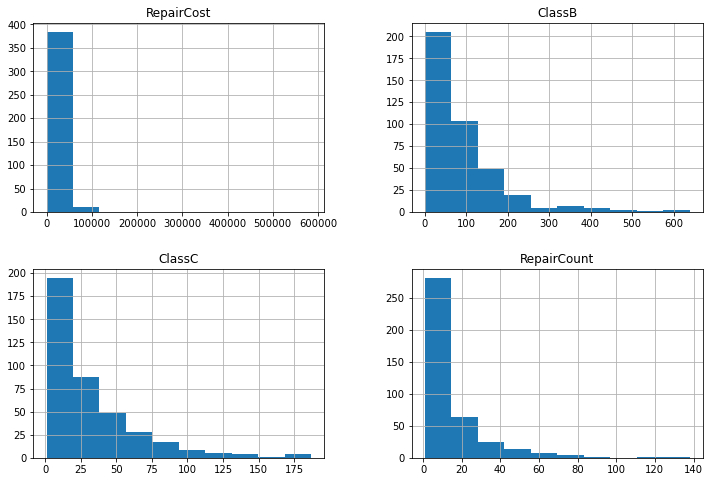

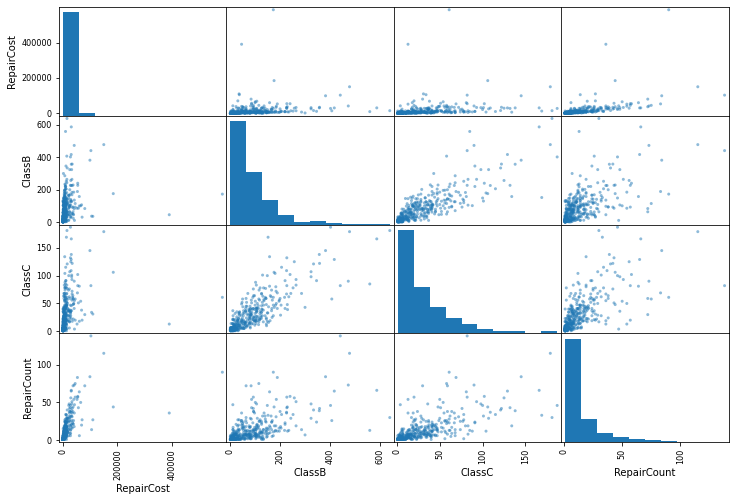

In [12]:
print('Histogram: \n',X_train.hist(figsize=(12,8)),'\n\nScatterplot Matrix: \n',scatter_matrix(X_train, figsize=(12,8)),'\n\n')

             RepairCost    ClassB    ClassC  RepairCount
RepairCost     1.000000  0.220953  0.262731     0.548139
ClassB         0.220953  1.000000  0.824132     0.630413
ClassC         0.262731  0.824132  1.000000     0.669359
RepairCount    0.548139  0.630413  0.669359     1.000000


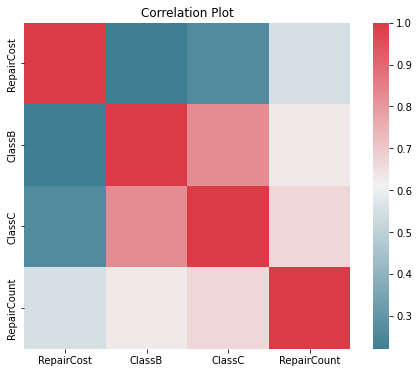

In [13]:
# Pearson correlation matrix
cor= X_train.corr(method='pearson')
print(cor)
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

['BBL', 'RepairCount', 'RepairCost', 'ClassB', 'ClassC']


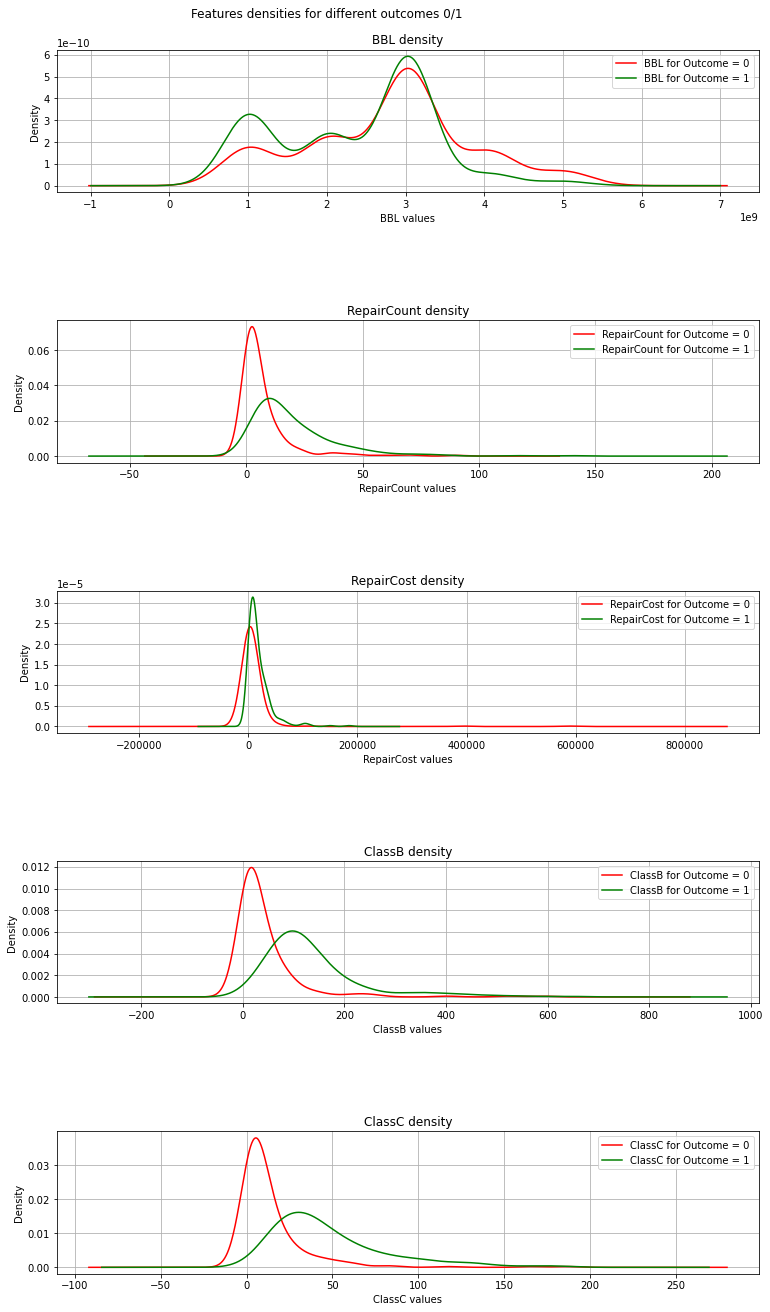

In [35]:
# creating correlation density plots
# this is to try and debug why the models weren't working (previous to down-sampling)

# tweaked from @SuperKogito, https://stackoverflow.com/questions/56153726/plot-k-nearest-neighbor-graph-with-8-features

def plot_densities(db):
    # plot size
    rcParams['figure.figsize'] = 15, 20
    # separate data based on outcome values 
    outcome_0 = db[db['AEP'] == 0]
    outcome_1 = db[db['AEP'] == 1]
    # init figure
    fig, axs = plt.subplots(5, 1)
    fig.suptitle('Features densities for different outcomes 0/1')
    plt.subplots_adjust(left = 0.25, right = 0.9, bottom = 0.1, top = 0.95,
                        wspace = 0.2, hspace = 0.9)
    # plot densities for outcomes
    for column_name in names[:]: 
        ax = axs[names.index(column_name)]
        #plt.subplot(4, 2, names.index(column_name) + 1)
        outcome_0[column_name].plot(kind='density', ax=ax, subplots=True, 
                                    sharex=False, color="red", legend=True,
                                    label=column_name + ' for Outcome = 0')
        outcome_1[column_name].plot(kind='density', ax=ax, subplots=True, 
                                     sharex=False, color="green", legend=True,
                                     label=column_name + ' for Outcome = 1')
        ax.set_xlabel(column_name + ' values')
        ax.set_title(column_name + ' density')
        ax.grid('on')
    plt.show()
    fig.savefig('densities.png')

# load your data 
plt_db = bg_sm[['AEP','BBL','RepairCount','RepairCost','ClassB','ClassC']]
names = list(plt_db.columns)
names.remove('AEP')
print(names)

# plot correlation & densities
plot_densities(plt_db)

In [15]:
# Step 2.4: apply two different supervised learning algorithms (default parameters)

# k-nearest neighbours
# this model seems a good fit, since we should be able to clearly group buildings in disrepair 
# k = 5
# fitting to the DOWNSAMPLED dataset.
knn_plain = KNeighborsClassifier(n_neighbors=5)
knn_plain.fit(X_train, y_train)
print("knn score: {}".format(knn_plain.score(X_train, y_train)))

knn score: 0.8467336683417085


In [16]:
# running the KNN model on the UNSAMPLED dataset.
knn_pred = knn_plain.predict(X_test_sl)

In [17]:
# gradient-boosted decision tree

# first, tried decision trees.
# this model seemed like a good fit, since there should be a logical hierarchy for the enforcement decision
# we have low-dimensional sparse mixed data, so curious about its performance
# while precision on "no" values was 0.99, precision on "yes" values was 0.06, so opting for random forest instead
# then, tried random forests; accuracy on both training and test sets was 0.992
# trying to see if I can boost performance with gradient pre-pruning.

# fitting to the DOWNSAMPLED dataset.

gbdt = GradientBoostingClassifier(
    n_estimators=200, 
    random_state=0, # for training
    #max_depth=2, # this appears to be optimal
    #learning_rate=0.1 # appears to be optimal
    )
gbdt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbdt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbdt.score(X_test, y_test)))

Accuracy on training set: 0.997
Accuracy on test set: 0.780


In [18]:
# running the GBDT model on the UNSAMPLED dataset.
gbdt_pred = gbdt.predict(X_test)

In [22]:
# the feature importances of the random forest:

print("Feature importances:")
print(pd.Series(gbdt.feature_importances_,index=X_train.columns))

Feature importances:
RepairCost     0.181967
ClassB         0.210392
ClassC         0.566005
RepairCount    0.041635
dtype: float64


In [23]:
# support vector machine
# this model seems a good fit, since the level of building disrepair could lend itself to a support hyperplane
# would require MinMaxScaler and VarianceThreshold before using, so leaving for future work

### Step 2.5: parameter adjustment

In [25]:
# k-nearest neighbours
# precision, recall, and F1 before adjusting
# reporting on DOWNSAMPLED predictors.
print(classification_report(y_test, knn_plain.predict(X_test),
                            target_names=["No AEP", "Yes AEP"]))

              precision    recall  f1-score   support

      No AEP       0.78      0.58      0.67        50
     Yes AEP       0.67      0.84      0.74        50

    accuracy                           0.71       100
   macro avg       0.73      0.71      0.71       100
weighted avg       0.73      0.71      0.71       100



In [26]:
# the initial model was telling me it couldn't find any values where it predicted AEP=1
# trying to debug, fixed it by downsampling negative values.

# the set of labels KNN found, for debug purposes.
set(knn_pred)

{0, 1}

In [27]:
# adjusting parameters using grid search
knn_seasoned = KNeighborsClassifier()
knn_param_grid = {"n_neighbors": np.arange(1, 25)} # setting boundaries on k

# grid search on all values of k in dictionary
# fitting to DOWNSAMPLED dataset.
knn_gscv = GridSearchCV(knn_seasoned, knn_param_grid, cv=5)
knn_gscv.fit(X_train, y_train)
print('\n\nBest parameters: ',knn_gscv.best_params_)



Best parameters:  {'n_neighbors': 5}


In [29]:
# report evaluation metrics for best- and worst- performing parameter settings
# evaluating using DOWNSAMPLED dataset.
print(classification_report(y_test, knn_gscv.predict(X_test),
                            target_names=["No AEP", "Yes AEP"]))

              precision    recall  f1-score   support

      No AEP       0.78      0.58      0.67        50
     Yes AEP       0.67      0.84      0.74        50

    accuracy                           0.71       100
   macro avg       0.73      0.71      0.71       100
weighted avg       0.73      0.71      0.71       100



In [30]:
# gradient-boosted random forest
# precision, recall, and F1
# evaluating on DOWNSAMPLED dataset.
print(classification_report(y_test, gbdt.predict(X_test),
                            target_names=["No AEP", "Yes AEP"]))

              precision    recall  f1-score   support

      No AEP       0.85      0.68      0.76        50
     Yes AEP       0.73      0.88      0.80        50

    accuracy                           0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100



In [31]:
# adjust 2-3 parameters using grid search
gbdt_seasoned = RandomForestClassifier(random_state=4)

# creating a dictionary with boundaries for each grid search parameter
gbdt_param_grid = { 
    'n_estimators': [200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [1,2,3,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

# fitting to DOWNSAMPLED dataset
gbdt_gscv = GridSearchCV(estimator=gbdt_seasoned, param_grid=gbdt_param_grid, cv=5)
gbdt_gscv.fit(X_train, y_train)

# listing the best parameters found by grid search
gbdt_gscv.best_params_

{'criterion': 'gini',
 'max_depth': 1,
 'max_features': 'sqrt',
 'n_estimators': 400}

In [34]:
# report evaluation metrics for best- and worst- performing parameter settings
# evaluating on DOWNSAMPLED dataset.
print(classification_report(y_test, gbdt_gscv.predict(X_test),
                            target_names=["No AEP", "Yes AEP"]))

              precision    recall  f1-score   support

      No AEP       0.83      0.70      0.76        50
     Yes AEP       0.74      0.86      0.80        50

    accuracy                           0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100

